## Import library 

In [1]:
import sys
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib'
)
import data_load
import numpy as np
import pandas as pd
import logging
import dowhy.datasets
import dowhy
import propensity_score_estimator as pse
import incremental_ps_score_estimator as ipse
import math
import timeit
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
from scipy.stats import sem
import scipy.stats as st
from dowhy import CausalModel
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem
from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference
from econml.dml import SparseLinearDMLCateEstimator
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from mlens.ensemble import SuperLearner
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
[MLENS] backend: threading


In [2]:
treatment = 't'
outcome = 'yf'
col =  ["t", "yf", "ycf", "mu0", "mu1" ]
cov = ["x" + str(i) for i in range(1,26)]
col = col + cov
features = cov + ["t"]

## Research continuous effect

In [3]:
index_ = 65
PATH_TRAIN = "/home/dtd/Downloads/ihdp_npci_1-100.train.npz"

data = utils.load_data(PATH_TRAIN, index_)

## Fit treatment
model_t = LogisticRegression()
model_t.fit(data[cov], data[treatment])

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(data[features], data[outcome])


data['p1'] = model_t.predict_proba(data[cov])[:,1]
data['p0'] = 1 - data['p1']

## Compute counterfactual outcome with no treatment
data_pos = data.copy()
data_pos[treatment] = 1
data['cf1'] = model_y.predict(data_pos[features])

## Compute counterfactual outcome with treatment
data_neg = data.copy()
data_neg[treatment] = 0
data['cf0'] = model_y.predict(data_neg[features])

data['ips_weight'] = (data[treatment] / data['p1'] + (1 - data[treatment]) /
                      (1 - data['p1']))

data['w0'] = data['ips_weight']*data[treatment]
data['w1'] = data['ips_weight']*(1 - data[treatment])


In [4]:
delta_seq = np.linspace(start = 0, stop = 200, num = 2000)

# mu, sigma = 50, 300 # mean and standard deviation
# delta_seq = np.random.normal(mu, sigma, 2000)


In [5]:
delta_seq = list(sorted(delta_seq))

In [6]:
true_effect = data['mu1'] - data['mu0']
means, stds = np.mean(true_effect, axis=0), sem(true_effect, axis=0)

In [7]:
delta = 25
influence = np.mean(ipse.influence_function(data, treatment, cov, outcome, features, delta, model_y, model_t))

print("Estimation effect {:.2f}".format(influence))
print("True effect {:.2f}".format(means))
mae = np.round(abs(influence - means),2)
print("MAE: {:.2f}".format(mae))

Estimation effect 4.14
True effect 4.17
MAE: 0.03


In [8]:
lowers_train, uppers_train = [], []
means_train = []

for i in tqdm(range(len(delta_seq))):
    data_expr = data.copy()
    delta = delta_seq[i]
    influence = ipse.influence_function(data_expr, treatment, cov, outcome, features, delta, model_y, model_t)

    mean_train, stds_incre_train = np.mean(influence, axis=0), sem(influence, axis=0)
    
    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influence)-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)

    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    means_train.append(mean_train)


100%|██████████| 2000/2000 [04:43<00:00,  7.06it/s]


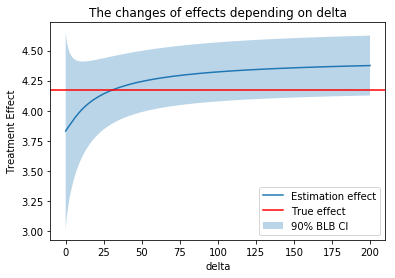

In [20]:
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=means, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend(loc = 4)
plt.show()